In [63]:
import torch
from torch import nn
from torch.nn import functional as F
from collections import namedtuple, deque
from torch.distributions import Categorical
from torch import optim
from torch import nn
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings 
warnings.simplefilter('ignore')
print('import all done')

import all done


# env

env action space is : 7
raw img shape is: (240, 256, 3)


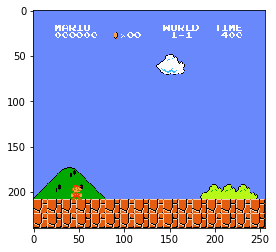

In [64]:
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
print('env action space is :',env.action_space.n)
state = env.reset()
print('raw img shape is:',state.shape)
plt.imshow(state)

# model

In [65]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1,4, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(4,8, kernel_size=4, stride=2)
        self.Flatten = nn.Sequential(nn.Flatten(),nn.Dropout(0.5))
        self.fc = nn.Linear(6720,128)
        self.lstm = nn.LSTMCell(128,128)
        self.actor = nn.Linear(128,7)
        self.critic = nn.Linear(128,1)
        
        self.hx = None
        self.cx = None
        
    def forward(self, x):
        x = self.process_obs(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.Flatten(x))
        x = F.relu(self.fc(x))
        
        # lstm 
        if self.hx is None:
            self.hx = torch.zeros((x.size()[0] ,128)).cuda()
            self.cx = torch.zeros((x.size()[0] ,128)).cuda()
        self.hx, self.cx = self.lstm(x, (self.hx, self.cx))
        
        # policy head and value head
        policy,value = self.actor(self.hx),self.critic(self.hx)
        
        return policy,value
    
    @classmethod
    def get_action(cls,policy):
        policy = F.softmax(policy)
        dist = Categorical(policy)
        action = dist.sample()
        return action.item()
    
    @classmethod
    def process_obs(cls,obs):
        obs = np.array([obs]) #(1,240,256,3)
        obs = torch.FloatTensor(obs) #(1,240,256,3)
        obs = obs[:,:,:,[0]] #(1,240,256,1)
        obs = obs.permute(0,3,1,2) # (1,1,240,256)
        obs = obs / 255.0 # range[0,1]
        return obs.cuda()
    
    def set_state(self, hx, cx):
        self.hx = hx
        self.cx = cx
    
    def reset_state(self):
        self.hx = None
        self.cx = None
    
    def get_state(self):
        if self.hx is None:
            return np.zeros((1,128), dtype=np.float32), np.zeros((1,128), dtype=np.float32)
        else:
            return self.hx.clone().detach().cpu().numpy(), self.cx.clone().detach().cpu().numpy()

# test env with model

In [66]:

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
net = ActorCritic().cuda()
state = env.reset()
for t in range(1000):
    env.render()
    action = net.get_action(net(state)[0])
    next_state,reward,done,info = env.step(action)
    state = next_state
env.close()

# agent

In [5]:
class PPOAgent(object):
    def __init__(self,env,gamma = 0.99,clip = 0.2,lr = 1e-3,K_epoch = 4):
        self.device = "cuda"
        self.env = env
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.clip = clip
        self.lr = lr
        self.K_epoch = K_epoch
        self.process_obs = process_obs
        self.net = ActorCritic().to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
            
    def act(self,state):
        state = torch.FloatTensor(state).to(self.device)
        probs,value = self.net(state)
        action = Categorical(probs).sample().detach().item()
        return action
    
    def compute_returns(self,rewards):
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + self.gamma*G
            returns.insert(0,G)
        returns = np.array([i for i in returns]).ravel()
        return torch.FloatTensor(returns).to(self.device).view(-1, 1)
    
    def update(self,trajectory):
        state = torch.FloatTensor([sarsd[0] for sars in trajectory]).to(self.device)
        action = torch.LongTensor([sarsd[1] for sars in trajectory]).to(self.device).view(-1, 1)
        returns = self.compute_returns([sarsd[2] for sars in trajectory])
        next_state = torch.FloatTensor([sarsd[3] for sars in trajectory]).to(self.device)
        done = torch.FloatTensor([sarsd[4] for sars in trajectory]).to(self.device).view(-1, 1)
        old_prob,_ = self.net(state)
        for _ in range(self.K_epoch):    
            new_prob,values = self.net(state)
            advantage = returns - values
            critic_loss = 0.5*(advantage**2).mean()
            new_p = torch.gather(new_prob,1,action)
            old_p = torch.gather(old_prob,1,action)
            ratio = new_p / old_p
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio,1 - self.clip,1 + self.clip) * advantage.detach()
            actor_loss = -torch.min(surr1,surr2).mean()
            loss = actor_loss + critic_loss
            loss.backward()
            self.net_optimizer.step()
            self.net_optimizer.zero_grad()
    
    def train(self,max_episodes):
        episode_rewards = []
        for episode in range(max_episodes):
            
            # initialize new game
            state = self.env.reset()
            state = self.process_obs(state)
            trajectory = [] # [[s, a, r, s', done], [], ...]
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.process_obs(next_state)
                trajectory.append([state, action, reward, next_state, done])
                episode_reward += reward
                state = next_state
            
            # game over
            print("Episode " + str(episode) + ": " + str(episode_reward))
            episode_rewards.append(episode_reward)
            self.update(trajectory)
        
        return episode_rewards
    
    def play(self,max_episodes):
        
        for episode in range(max_episodes):
            
            # initialize new game
            state = env.reset()
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                self.env.render()
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state
            
            # game over
            print("Episode " + str(episode) + ": " + str(episode_reward))
        
        self.env.close()

In [6]:
agent = PPOAgent(env)
history = agent.train(max_episodes=100)

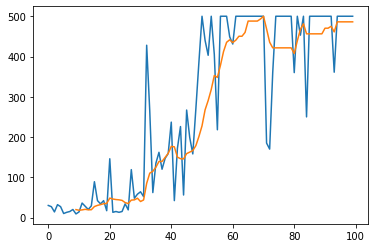

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history)
plt.plot(pd.Series(history).rolling(10).mean())

In [10]:
agent.play(max_episodes=10)

Episode 0: 500.0
Episode 1: 500.0
Episode 2: 500.0
Episode 3: 500.0
Episode 4: 500.0
Episode 5: 500.0
Episode 6: 500.0
Episode 7: 216.0
Episode 8: 500.0
Episode 9: 500.0
